# Comparative Analysis of N-grams, Language Model, and Embedding Techniques in Sentiment Analysis

The data used in this notebook is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the Yelp Dataset Challenge 2015 data. It is first used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

There are 650,000 training samples and 50,000 testing samples. Each set has the same number review star from 1 to 5. 

Only 2 columns are in the data set, corresponding to class index (1 to 5) and review text.

- [N-grams](#bag)
- [Zero-shot gemini model](#zero)
- [Gemini embedding](#embed)

In [85]:
import os
import sys
import datetime
import time
from tqdm.auto import tqdm
from dotenv import load_dotenv, find_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold
from google.api_core import retry
from sklearn.metrics import auc, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,\
RocCurveDisplay, roc_curve, PrecisionRecallDisplay, precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, RFE, RFECV, SelectFromModel, SequentialFeatureSelector, \
mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn import __version__ as sklearn_version
import xgboost as xgb
import lightgbm as lgb
import optuna
from optuna.visualization import plot_optimization_history
from joblib import dump, load

In [2]:
train = pd.read_csv('../data/raw/train.csv', header=None)
train.columns = ['y', 'X']
train

,y,X
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...
...,...,...
649995,5,I had a sprinkler that was gushing... pipe bro...
649996,1,Phone calls always go to voicemail and message...
649997,1,Looks like all of the good reviews have gone t...
649998,5,I was able to once again rely on Yelp to provi...


In [122]:
f = lambda x: x.str.len().mean()
train.groupby('y').X.agg(f)

y
1    815.307762
2    827.625792
3    758.695454
4    680.159985
5    579.838346
Name: X, dtype: float64

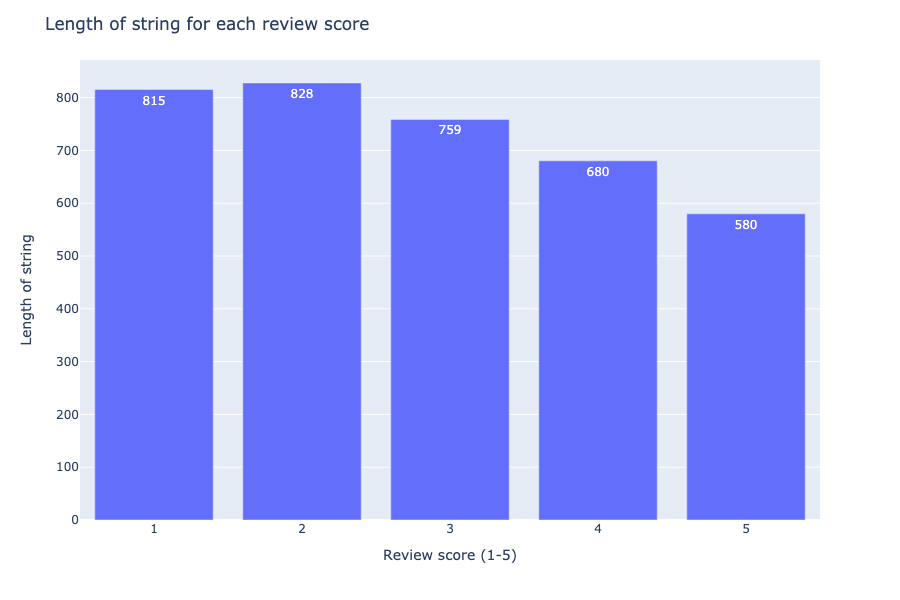

In [131]:
fig = px.bar(x=range(1,6), y=train.groupby('y').X.agg(f), text_auto='d', width=900, height=600)
fig.update_xaxes(title='Review score (1-5)')
fig.update_yaxes(title='Length of string')
fig.update_layout(title = 'Length of string for each review score')
fig.show('png')

On average, low review score has longer text.

In [3]:
X_train = train.X
y_train = train.y

In [5]:
test = pd.read_csv('../data/raw/test.csv', header=None)
test.columns = ['y', 'X']
test

,y,X
0,1,I got 'new' tires from them and within two wee...
1,1,Don't waste your time. We had two different p...
2,1,All I can say is the worst! We were the only 2...
3,1,I have been to this restaurant twice and was d...
4,1,Food was NOT GOOD at all! My husband & I ate h...
...,...,...
49995,1,Just wanted to write a review to chip in with ...
49996,5,Great ambience. Great drinks. Great food. I lo...
49997,4,I have been to the other Monks locations so I ...
49998,2,Don't go here. I know you might want to try i...


In [6]:
X_test = test.X
y_test = test.y

In [8]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# N-grams<a id='bag'><a>

Compare different N-grams.

In [186]:
steps = [('hash', HashingVectorizer(stop_words='english')), ('tfid', TfidfTransformer()),('lgbc',lgb.LGBMClassifier())]
pipeline_bw = Pipeline(steps)
ngram = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
parameters = {'hash__ngram_range':ngram}
lgb_bw_cv = GridSearchCV(pipeline_bw, param_grid=parameters, scoring='accuracy', cv=kf)
lgb_bw_cv.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.373792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280505
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 27697
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 7.451606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1286183
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 27768
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] St

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 532.164956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7881185
[LightGBM] [Info] Number of data points in the train set: 433334, number of used features: 765008
[LightGBM] [Info] Start training from score -1.609436
[LightGBM] [Info] Start training from score -1.609436
[LightGBM] [Info] Start training from score -1.609436
[LightGBM] [Info] Start training from score -1.609447
[LightGBM] [Info] Start training from score -1.609436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 151.503140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1747324
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 240835
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [In

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('hash',
                                        HashingVectorizer(stop_words='english')),
                                       ('tfid', TfidfTransformer()),
                                       ('lgbc', LGBMClassifier())]),
             param_grid={'hash__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2),
                                               (2, 3), (3, 3)]},
             scoring='accuracy')

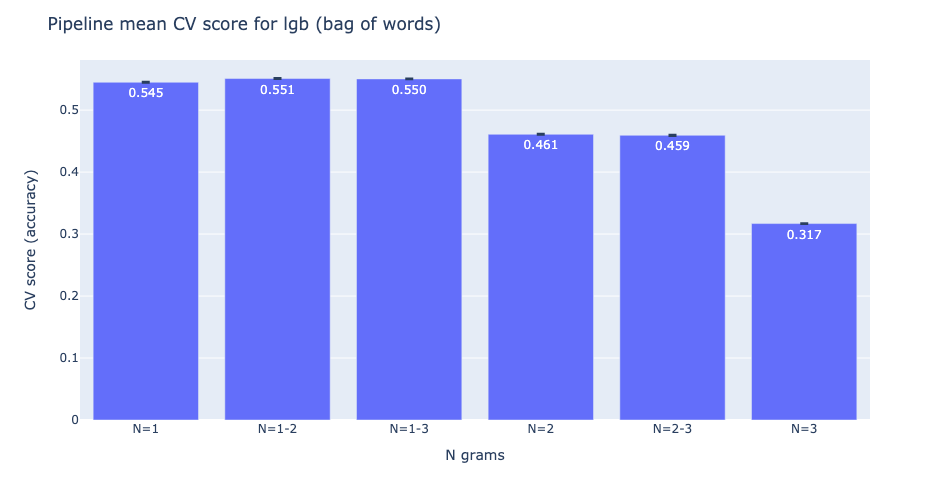

In [195]:
score_mean = lgb_bw_cv.cv_results_['mean_test_score']
score_std = lgb_bw_cv.cv_results_['std_test_score']

fig = px.bar(x=['N=1','N=1-2','N=1-3','N=2','N=2-3','N=3'], y=score_mean, error_y=score_std, text_auto='.3f')

fig.update_xaxes(title_text='N grams')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for lgb (bag of words)',
                  yaxis_title='CV score (accuracy)', width=950, height=500)

fig.show('png')

N=1-2 has the best score.

Use Baysian optimization.

In [196]:
def lgb_bw_eval(trial):
    num_leaves = trial.suggest_int('num_leaves', 10, 50)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    min_split_gain = trial.suggest_float('min_split_gain', 0, 1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 50)
    
    lgb_param_grid = {'objective':'multiclass', 'num_leaves':num_leaves,'n_estimators':n_estimators, 'max_depth':max_depth,
                      'learning_rate':learning_rate, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                      'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_split_gain':min_split_gain,
                      'min_child_weight':min_child_weight, 'min_child_samples':min_child_samples,'verbosity':-1}
    
    steps = [('hash', HashingVectorizer(stop_words='english', ngram_range=(1,2))), ('tfid', TfidfTransformer()),
             ('lgbc',lgb.LGBMClassifier(**lgb_param_grid))]
    pipeline_bw = Pipeline(steps)
    score = cross_val_score(pipeline_bw, X_train, y_train, scoring='accuracy', cv=kf)
    return score.mean()

In [199]:
sampler = optuna.samplers.TPESampler(seed=0)
lgb_bw_study = optuna.create_study(direction='maximize', sampler=sampler)
lgb_bw_study.optimize(lgb_bw_eval, n_trials=10)

[I 2024-03-23 12:53:07,081] A new study created in memory with name: no-name-38b33700-d3d6-44be-b274-8a1b2dbea34a
[I 2024-03-23 13:17:02,958] Trial 0 finished with value: 0.5668953867103791 and parameters: {'num_leaves': 32, 'n_estimators': 386, 'max_depth': 13, 'learning_rate': 0.544887734165067, 'reg_alpha': 0.4236547993389047, 'reg_lambda': 0.6458941130666561, 'subsample': 0.4432113391500656, 'colsample_bytree': 0.892855270774259, 'min_split_gain': 0.9636627605010293, 'min_child_weight': 3.8960710363751994, 'min_child_samples': 40}. Best is trial 0 with value: 0.5668953867103791.
[I 2024-03-23 13:51:17,413] Trial 1 finished with value: 0.5706323093352482 and parameters: {'num_leaves': 31, 'n_estimators': 327, 'max_depth': 19, 'learning_rate': 0.07104534783730497, 'reg_alpha': 0.08712929970154071, 'reg_lambda': 0.02021839744032572, 'subsample': 0.8342936470924586, 'colsample_bytree': 0.780375183440352, 'min_split_gain': 0.8700121482468192, 'min_child_weight': 9.788321588104363, 'min_

In [10]:
best_trial_bw = lgb_bw_study.best_trial
best_params_lgb_bw = best_trial_bw.params
best_params_lgb_bw['objective'] = 'multiclass'

In [11]:
best_params_lgb_bw

{'num_leaves': 31,
 'n_estimators': 327,
 'max_depth': 19,
 'learning_rate': 0.07104534783730497,
 'reg_alpha': 0.08712929970154071,
 'reg_lambda': 0.02021839744032572,
 'subsample': 0.8342936470924586,
 'colsample_bytree': 0.780375183440352,
 'min_split_gain': 0.8700121482468192,
 'min_child_weight': 9.788321588104363,
 'min_child_samples': 40,
 'objective': 'multiclass'}

Refit with best hyperparameters.

In [13]:
steps = [('hash', HashingVectorizer(stop_words='english', ngram_range=(1,2))), ('tfid', TfidfTransformer()),
             ('lgbc',lgb.LGBMClassifier(**best_params_lgb_bw))]
pipeline_bw = Pipeline(steps)
pipeline_bw.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 96.799890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3680529
[LightGBM] [Info] Number of data points in the train set: 650000, number of used features: 187185
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


Pipeline(steps=[('hash',
                 HashingVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('tfid', TfidfTransformer()),
                ('lgbc',
                 LGBMClassifier(colsample_bytree=0.780375183440352,
                                learning_rate=0.07104534783730497, max_depth=19,
                                min_child_samples=40,
                                min_child_weight=9.788321588104363,
                                min_split_gain=0.8700121482468192,
                                n_estimators=327, objective='multiclass',
                                reg_alpha=0.08712929970154071,
                                reg_lambda=0.02021839744032572,
                                subsample=0.8342936470924586))])

In [15]:
y_pred_bw = pipeline_bw.predict(X_test)
print(accuracy_score(y_test, y_pred_bw))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
0.56876


In [54]:
pd.Series(y_pred_bw).value_counts()

1    11173
5    10952
4     9537
2     9248
3     9090
Name: count, dtype: int64

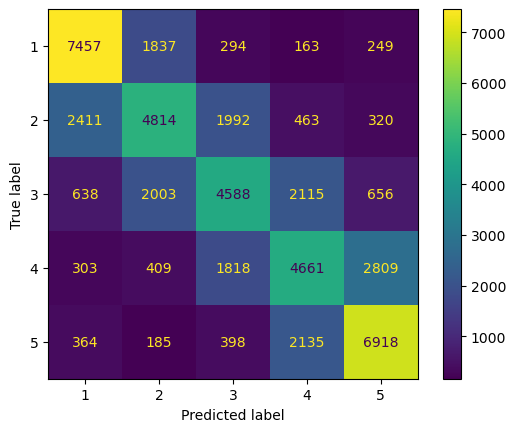

In [16]:
cm = confusion_matrix(y_test, y_pred_bw)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
cmd.plot()
plt.show()

In [17]:
print(classification_report(y_test, y_pred_bw))

              precision    recall  f1-score   support

           1       0.67      0.75      0.70     10000
           2       0.52      0.48      0.50     10000
           3       0.50      0.46      0.48     10000
           4       0.49      0.47      0.48     10000
           5       0.63      0.69      0.66     10000

    accuracy                           0.57     50000
   macro avg       0.56      0.57      0.56     50000
weighted avg       0.56      0.57      0.56     50000



frequency of 1 and 5 are slightly higher, and have better precision and recall than 2,3, and 4. The differences between precision and recall for each class is not large. Approximately 0.5 and 0.7 F1-scores for class 2,3,4 and 1,5, respectively.

In [18]:
lgb_bw_model = pipeline_bw
lgb_bw_model.version = '1.0'
lgb_bw_model.python_version = sys.version
lgb_bw_model.pandas_version = pd.__version__
lgb_bw_model.numpy_version = np.__version__
lgb_bw_model.sklearn_version = sklearn_version
lgb_bw_model.lightgbm_version = lgb.__version__
lgb_bw_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
dump(lgb_bw_model, f'{modelpath}/lgb_bw_model.joblib')

['../models/lgb_bw_model.joblib']

***

# Zero-shot gemini model<a id='zero'><a>

In [86]:
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

gemini_key = os.environ.get("GEMINI_KEY")

In [87]:
genai.configure(api_key=gemini_key)

List the model.

In [88]:
for m in genai.list_models():
    if 'generateContent' in m.supported_generation_methods:
        print(m.name)

models/gemini-1.0-pro
models/gemini-1.0-pro-001
models/gemini-1.0-pro-latest
models/gemini-1.0-pro-vision-latest
models/gemini-pro
models/gemini-pro-vision


Use 'gemini-1.0-pro', disable safety (so the prompt should not be block), and set temperature to zero to model deterministic.

In [89]:
model = genai.GenerativeModel('gemini-1.0-pro', 
                              safety_settings={
                                  HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
                                  HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
                                  HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
                                  HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE},
                              generation_config=genai.GenerationConfig(temperature = 0.0))

## Zero-shot prompt

In [692]:
def single(X: str)->list:
    '''Make a signle response from a single comment'''
    front = 'Classify sentiment from 1-5 (negative-positive) for the following statement: '
    back = '. Respond with a single digit, 1 for the most negative, 2 for slightly negative, 3 for neutral, 4 for slightly positive, and 5 for the most positive.'
    response = model.generate_content(front+X+back)
    # If the block reason is not unknown (2), return the response otherwise return -1.
    if response.prompt_feedback.block_reason.value != 2:
        return int(response.text)
    else: 
        return -1

Some reviews contain too many inappropiate words that the model does not give any response. A solution is to cut out a part of the review starting from the end.

In [634]:
def make_resp(X:str):
    for i in np.arange(0, 1, 0.1):
        # Start off with full reviews if the response is blocked, cut the review by 10% at a time
        if i==0:
            s = single(X)
        else:
            s = single(X[:-int(i*len(X))])
        # if the response is not blocked, break out of loop
        if s != -1:
            break
    return s

In [709]:
y_pred_gemini = []
for i in X_test[41151:]:
    y_pred_gemini.append(make_resp(i))
    print(len(y_pred_gemini), end='\r')
    # Set a time delay so that queries do not exceed the model limit
    time.sleep(0.5)

Check and save data.

In [711]:
gemini_pred_df = pd.DataFrame({'y_pred_gemini':y_pred_gemini})

In [712]:
gemini_pred_df.value_counts()

y_pred_gemini
5                15055
1                15000
4                 7867
2                 7720
3                 4358
Name: count, dtype: int64

In [713]:
gemini_pred_df.to_csv('../data/processed/y_pred_gemini.csv', index=False)

In [44]:
accuracy_score(y_test, y_pred_gemini)

0.58552

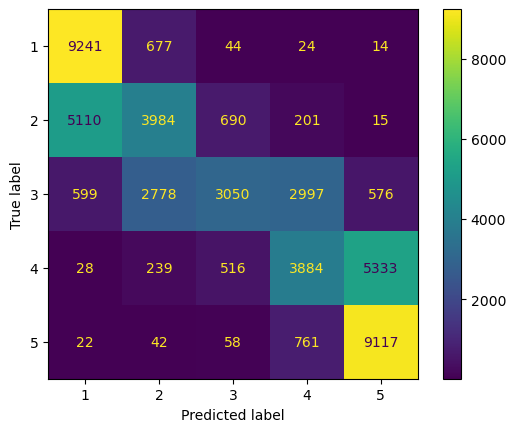

In [782]:
cm = confusion_matrix(y_test, y_pred_gemini)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
cmd.plot()
plt.show()

In [45]:
print(classification_report(y_test, y_pred_gemini))

              precision    recall  f1-score   support

           1       0.62      0.92      0.74     10000
           2       0.52      0.40      0.45     10000
           3       0.70      0.30      0.42     10000
           4       0.49      0.39      0.43     10000
           5       0.61      0.91      0.73     10000

    accuracy                           0.59     50000
   macro avg       0.59      0.59      0.56     50000
weighted avg       0.59      0.59      0.56     50000



More than 60% of the predicted values are 1 and 5 so the recalls of those class are quite high. On the contary, less than 10% of the prediction is 3, but its precision is quite high at 70%. Thus, there is a big gap between precision and recall in each class, especially 1,3, and 5. This model has slightly better F1-score on class 1 and 5 and worse on class 2,3,4.

***

# Embedding<a id='embed'><a>

Embedding model

In [11]:
for m in genai.list_models():
    if 'embedContent' in m.supported_generation_methods:
        print(m.name)

models/embedding-001


Embedding X_train and X_test.

In [12]:
def gen_embed(text, model='models/embedding-001'):
    result = genai.embed_content(model, content=text, task_type='classification')
    return result['embedding']

In [13]:
%%time
X_train_gemini_embedding = pd.DataFrame(gen_embed(X_train))

CPU times: user 16min 40s, sys: 31min 47s, total: 48min 27s
Wall time: 2h 25min 50s


In [14]:
%%time
X_test_gemini_embedding = pd.DataFrame(gen_embed(X_test))

CPU times: user 1min 6s, sys: 2.45 s, total: 1min 9s
Wall time: 7min 39s


In [18]:
X_train_gemini_embedding.to_csv('../data/processed/X_train_gemini_embedding.csv', index=False)

In [19]:
X_test_gemini_embedding.to_csv('../data/processed/X_test_gemini_embedding.csv', index=False)

In [40]:
%%time
lgbc = lgb.LGBMClassifier(objective='multiclass')
score_xgb = cross_val_score(lgbc, X_train_gemini_embedding, y_train, scoring='accuracy', cv=kf)
score_xgb

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.528245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 520000, number of used features: 768
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.549674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 520000, number of used features: 768
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training fro

array([0.64905385, 0.64874615, 0.6485    , 0.65240769, 0.64847692])

Hyperparameter optimization

In [48]:
def lgb_eval(trial):
    num_leaves = trial.suggest_int('num_leaves', 10, 50)
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
#    gamma = trial.suggest_float('gamma', 0, 1)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    subsample = trial.suggest_float('subsample', 0.01, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    min_split_gain = trial.suggest_float('min_split_gain', 0, 1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 1, 50)
    
    lgb_param_grid = {'objective':'multiclass', 'num_leaves':num_leaves,'n_estimators':n_estimators, 'max_depth':max_depth,
                      'learning_rate':learning_rate, 'reg_alpha':reg_alpha, 'reg_lambda':reg_lambda,
                      'subsample':subsample, 'colsample_bytree':colsample_bytree, 'min_split_gain':min_split_gain,
                      'min_child_weight':min_child_weight, 'min_child_samples':min_child_samples,'verbosity':-1}
    
    lgbc = lgb.LGBMClassifier(**lgb_param_grid)
    score = cross_val_score(lgbc, X_train_gemini_embedding, y_train, scoring='accuracy', cv=kf)
    return score.mean()

In [50]:
sampler = optuna.samplers.TPESampler(seed=0)
lgb_study = optuna.create_study(direction='maximize', sampler=sampler)
lgb_study.optimize(lgb_eval, n_trials=100)

[I 2024-03-20 18:04:34,272] A new study created in memory with name: no-name-af865acd-e843-4517-b191-e1e067f78073
[I 2024-03-20 18:13:03,731] Trial 0 finished with value: 0.6371476920716548 and parameters: {'num_leaves': 32, 'n_estimators': 386, 'max_depth': 13, 'learning_rate': 0.544887734165067, 'reg_alpha': 0.4236547993389047, 'reg_lambda': 0.6458941130666561, 'subsample': 0.4432113391500656, 'colsample_bytree': 0.892855270774259, 'min_split_gain': 0.9636627605010293, 'min_child_weight': 3.8960710363751994, 'min_child_samples': 40}. Best is trial 0 with value: 0.6371476920716548.
[I 2024-03-20 18:25:18,977] Trial 1 finished with value: 0.6679261535132205 and parameters: {'num_leaves': 31, 'n_estimators': 327, 'max_depth': 19, 'learning_rate': 0.07104534783730497, 'reg_alpha': 0.08712929970154071, 'reg_lambda': 0.02021839744032572, 'subsample': 0.8342936470924586, 'colsample_bytree': 0.780375183440352, 'min_split_gain': 0.8700121482468192, 'min_child_weight': 9.788321588104363, 'min_

[I 2024-03-20 19:39:33,959] Trial 17 finished with value: 0.6692953842848245 and parameters: {'num_leaves': 36, 'n_estimators': 429, 'max_depth': 4, 'learning_rate': 0.20288490074450688, 'reg_alpha': 0.7131309866969738, 'reg_lambda': 0.3859173193615239, 'subsample': 0.15643796556603615, 'colsample_bytree': 0.28445776376572646, 'min_split_gain': 0.44513388360002726, 'min_child_weight': 2.1394228115113725, 'min_child_samples': 24}. Best is trial 4 with value: 0.6705246150232919.
[I 2024-03-20 19:48:47,305] Trial 18 finished with value: 0.6458215385142999 and parameters: {'num_leaves': 47, 'n_estimators': 498, 'max_depth': 11, 'learning_rate': 0.4300101948538039, 'reg_alpha': 0.7983373579959614, 'reg_lambda': 0.551627190517547, 'subsample': 0.6069789178933088, 'colsample_bytree': 0.45884698769621973, 'min_split_gain': 0.0022652556785879296, 'min_child_weight': 3.681246629098847, 'min_child_samples': 2}. Best is trial 4 with value: 0.6705246150232919.
[I 2024-03-20 19:51:18,910] Trial 19 f

[I 2024-03-20 21:28:23,215] Trial 35 finished with value: 0.6633323071345002 and parameters: {'num_leaves': 32, 'n_estimators': 333, 'max_depth': 14, 'learning_rate': 0.04615911761696255, 'reg_alpha': 0.4993934882585301, 'reg_lambda': 0.2123516971301217, 'subsample': 0.36600632914013054, 'colsample_bytree': 0.36375470439734897, 'min_split_gain': 0.32216439190142854, 'min_child_weight': 8.678599373411128, 'min_child_samples': 41}. Best is trial 34 with value: 0.6734553846233062.
[I 2024-03-20 21:38:38,886] Trial 36 finished with value: 0.5756138456784637 and parameters: {'num_leaves': 31, 'n_estimators': 452, 'max_depth': 10, 'learning_rate': 0.00043880218413200334, 'reg_alpha': 0.49948341578207633, 'reg_lambda': 0.05882377567577407, 'subsample': 0.4427399450049791, 'colsample_bytree': 0.40125919628853374, 'min_split_gain': 0.20810797897829578, 'min_child_weight': 0.7610490554568046, 'min_child_samples': 37}. Best is trial 34 with value: 0.6734553846233062.
[I 2024-03-20 21:44:27,443] T

[I 2024-03-20 23:26:16,852] Trial 53 finished with value: 0.6729815382256706 and parameters: {'num_leaves': 29, 'n_estimators': 468, 'max_depth': 9, 'learning_rate': 0.09880104741445947, 'reg_alpha': 0.5981255322645904, 'reg_lambda': 0.3391241273920075, 'subsample': 0.584955159232211, 'colsample_bytree': 0.4087204756867703, 'min_split_gain': 0.1238781510429548, 'min_child_weight': 4.221797647786339, 'min_child_samples': 37}. Best is trial 34 with value: 0.6734553846233062.
[I 2024-03-20 23:33:01,832] Trial 54 finished with value: 0.6700199993925198 and parameters: {'num_leaves': 29, 'n_estimators': 317, 'max_depth': 9, 'learning_rate': 0.0942968269450496, 'reg_alpha': 0.5908979672765029, 'reg_lambda': 0.3185582610000272, 'subsample': 0.595778995731887, 'colsample_bytree': 0.4191270139337713, 'min_split_gain': 0.11832366602620194, 'min_child_weight': 0.9208238285997727, 'min_child_samples': 30}. Best is trial 34 with value: 0.6734553846233062.
[I 2024-03-20 23:37:20,024] Trial 55 finish

[I 2024-03-21 01:19:20,390] Trial 71 finished with value: 0.6719523074706362 and parameters: {'num_leaves': 16, 'n_estimators': 459, 'max_depth': 7, 'learning_rate': 0.10496898128655247, 'reg_alpha': 0.6998919048987048, 'reg_lambda': 0.4993457022496752, 'subsample': 0.8441689864383015, 'colsample_bytree': 0.3950253375190189, 'min_split_gain': 0.09652163389019236, 'min_child_weight': 7.652148581026628, 'min_child_samples': 38}. Best is trial 34 with value: 0.6734553846233062.
[I 2024-03-21 01:24:11,444] Trial 72 finished with value: 0.6720292319274433 and parameters: {'num_leaves': 13, 'n_estimators': 473, 'max_depth': 6, 'learning_rate': 0.1312785017965166, 'reg_alpha': 0.6690886346599705, 'reg_lambda': 0.37830813683339604, 'subsample': 0.9089366466336383, 'colsample_bytree': 0.31535999096140593, 'min_split_gain': 0.037119046764082474, 'min_child_weight': 6.687294254206982, 'min_child_samples': 38}. Best is trial 34 with value: 0.6734553846233062.
[I 2024-03-21 01:31:41,364] Trial 73 f

[I 2024-03-21 03:21:24,393] Trial 89 finished with value: 0.6700861536410416 and parameters: {'num_leaves': 37, 'n_estimators': 474, 'max_depth': 7, 'learning_rate': 0.15987243792313244, 'reg_alpha': 0.5462290090568372, 'reg_lambda': 0.4522703093404978, 'subsample': 0.7211409788164429, 'colsample_bytree': 0.3884819803402155, 'min_split_gain': 0.0490481031032837, 'min_child_weight': 5.59521729195413, 'min_child_samples': 39}. Best is trial 34 with value: 0.6734553846233062.
[I 2024-03-21 03:25:35,182] Trial 90 finished with value: 0.6692400005996185 and parameters: {'num_leaves': 20, 'n_estimators': 499, 'max_depth': 10, 'learning_rate': 0.1897241148614383, 'reg_alpha': 0.03445314177331238, 'reg_lambda': 0.22976592291957898, 'subsample': 0.6619338124698473, 'colsample_bytree': 0.2195844048716728, 'min_split_gain': 0.17371338433053307, 'min_child_weight': 7.397462468876616, 'min_child_samples': 14}. Best is trial 34 with value: 0.6734553846233062.
[I 2024-03-21 03:32:54,338] Trial 91 fin

In [54]:
best_trial = lgb_study.best_trial
best_params_lgb_gemini_embed = best_trial.params
best_params_lgb_gemini_embed['objective'] = 'multiclass'

In [55]:
best_params_lgb_gemini_embed

{'num_leaves': 42,
 'n_estimators': 447,
 'max_depth': 16,
 'learning_rate': 0.07941304336225966,
 'reg_alpha': 0.5182624767023166,
 'reg_lambda': 0.27547381160766937,
 'subsample': 0.7892423313100339,
 'colsample_bytree': 0.26273930998695766,
 'min_split_gain': 0.1847234296567482,
 'min_child_weight': 3.995597484766487,
 'min_child_samples': 48,
 'objective': 'multiclass'}

In [72]:
lgb_gemini_embedding = lgb.LGBMClassifier(**best_params_lgb_gemini_embed)
lgb_gemini_embedding.fit(X_train_gemini_embedding, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.576438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 650000, number of used features: 768
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


LGBMClassifier(colsample_bytree=0.26273930998695766,
               learning_rate=0.07941304336225966, max_depth=16,
               min_child_samples=48, min_child_weight=3.995597484766487,
               min_split_gain=0.1847234296567482, n_estimators=447,
               num_leaves=42, objective='multiclass',
               reg_alpha=0.5182624767023166, reg_lambda=0.27547381160766937,
               subsample=0.7892423313100339)

In [73]:
y_pred_gemini_embedding = lgb_gemini_embedding.predict(X_test_gemini_embedding)
print(accuracy_score(y_test, y_pred_gemini_embedding))

0.67134


In [61]:
pd.Series(y_pred_gemini_embedding).value_counts()

2    10306
4    10134
5    10071
1    10041
3     9448
Name: count, dtype: int64

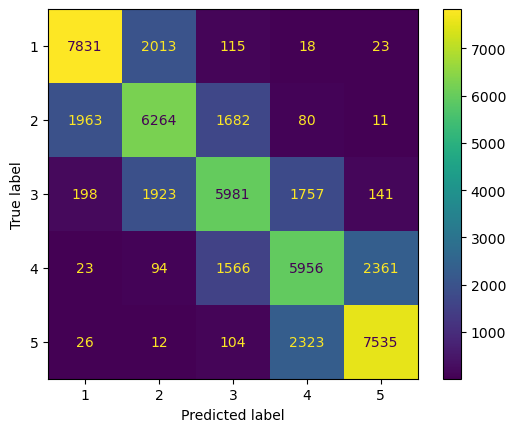

In [78]:
cm = confusion_matrix(y_test, y_pred_gemini_embedding)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
cmd.plot()
plt.show()

In [161]:
print(classification_report(y_test, y_pred_gemini_embedding))

              precision    recall  f1-score   support

           1       0.78      0.78      0.78     10000
           2       0.61      0.63      0.62     10000
           3       0.63      0.60      0.62     10000
           4       0.59      0.60      0.59     10000
           5       0.75      0.75      0.75     10000

    accuracy                           0.67     50000
   macro avg       0.67      0.67      0.67     50000
weighted avg       0.67      0.67      0.67     50000



Prediction has quite balanced class. Better performance overall.

In [74]:
lgb_gemini_embedding_model = lgb_gemini_embedding
lgb_gemini_embedding_model.version = '1.0'
lgb_gemini_embedding_model.python_version = sys.version
lgb_gemini_embedding_model.pandas_version = pd.__version__
lgb_gemini_embedding_model.numpy_version = np.__version__
lgb_gemini_embedding_model.sklearn_version = sklearn_version
lgb_gemini_embedding_model.lightgbm_version = lgb.__version__
lgb_gemini_embedding_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
dump(lgb_gemini_embedding_model, f'{modelpath}/lgb_gemini_embedding_model.joblib')

['../models/lgb_gemini_embedding_model.joblib']

***

# Dimensionality reduction

In [63]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_gemini_embedding)

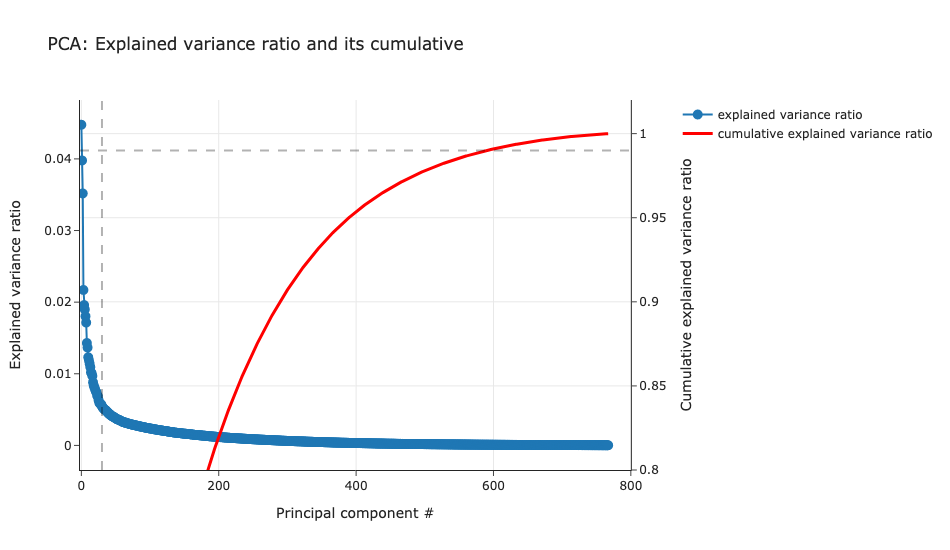

In [65]:
exp_var_ratio = pca.explained_variance_ratio_
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio, name='explained variance ratio',
                         mode='lines+markers', marker=dict(size=10)), secondary_y=False)
fig.add_trace(go.Scatter(x=np.arange(0, len(exp_var_ratio)), y=exp_var_ratio.cumsum(), 
                         name='cumulative explained variance ratio',
                         mode='lines', line=dict(color='red', width=3)), secondary_y=True)

fig.add_vline(x=30, line_width=2, line_dash="dash")
fig.add_hline(y=0.99, line_width=2, line_dash="dash", secondary_y=True)

fig.update_xaxes(range=[-2, 800],showgrid=True)

fig.update_yaxes(title_text="Explained variance ratio", showgrid=False,secondary_y=False)
fig.update_yaxes(title_text="Cumulative explained variance ratio", showgrid=True, range=[0.8,1.02],secondary_y=True)

fig.update_layout(template = 'simple_white', title='PCA: Explained variance ratio and its cumulative',
                  xaxis_title='Principal component #', showlegend=True, width=950, height=550)
fig.show('png')

In [99]:
steps = [('pca', PCA()), ('lgb', lgb.LGBMClassifier(**best_params_lgb_gemini_embed))]
pipeline_pca = Pipeline(steps)
score = cross_val_score(pipeline_pca, X_train_gemini_embedding, y_train, scoring='accuracy', cv=kf)
score.mean()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.313009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 768
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.361078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 768
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training fro

0.6777169242185944

PCA increases the cv score from 0.674 to 0.678. Do gridsearch to find best n.

In [146]:
steps = [('pca', PCA()), ('lgb', lgb.LGBMClassifier(**best_params_lgb_gemini_embed))]
pipeline_pca_lgb = Pipeline(steps)
st = int(X_train_gemini_embedding.shape[1]/16)
n = [n for n in range(st, X_train_gemini_embedding.shape[1]+1, st)]
parameters = {'pca__n_components':n}
lgb_pca_cv = GridSearchCV(pipeline_pca_lgb, param_grid=parameters, scoring='accuracy', cv=kf)
lgb_pca_cv.fit(X_train_gemini_embedding, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 48
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 48
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start traini

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73440
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 288
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73440
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 288
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training from 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134640
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 528
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134640
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 528
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training fro

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.346619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 768
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.370737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 433333, number of used features: 768
[LightGBM] [Info] Start training from score -1.609433
[LightGBM] [Info] Start training from score -1.609445
[LightGBM] [Info] Start training fro

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('lgb',
                                        LGBMClassifier(colsample_bytree=0.26273930998695766,
                                                       learning_rate=0.07941304336225966,
                                                       max_depth=16,
                                                       min_child_samples=48,
                                                       min_child_weight=3.995597484766487,
                                                       min_split_gain=0.1847234296567482,
                                                       n_estimators=447,
                                                       num_leaves=42,
                                                       objective='multiclass',
                                                       reg_alpha=0.5182624767023166,
                                                       reg_lambda=0.27547381160766937,
                                                       subsample=0.7892423313100339))]),
             param_grid={'pca__n_components': [48, 96, 144, 192, 240, 288, 336,
                                               384, 432, 480, 528, 576, 624,
                                               672, 720, 768]},
             scoring='accuracy')

In [147]:
lgb_pca_cv.best_params_, lgb_pca_cv.best_score_

({'pca__n_components': 720}, 0.6782784626896031)

python(37218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


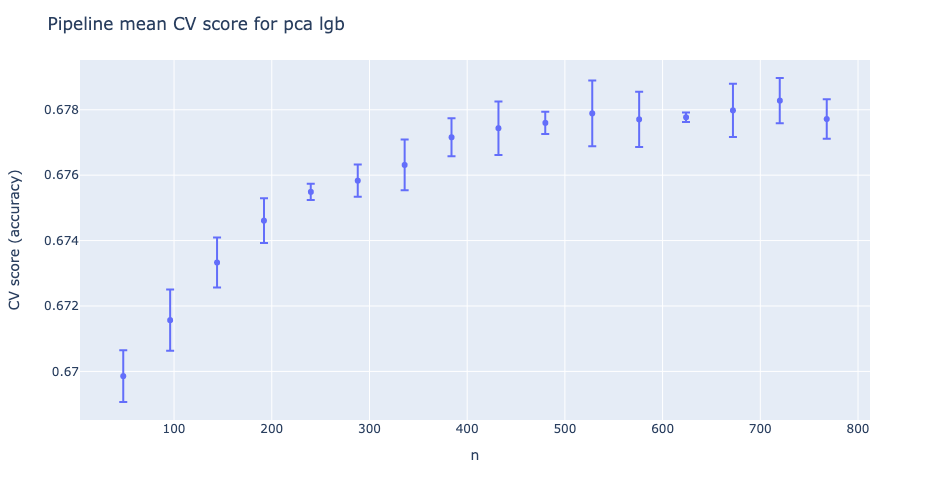

In [149]:
score_mean = lgb_pca_cv.cv_results_['mean_test_score']
score_std = lgb_pca_cv.cv_results_['std_test_score']

fig = px.scatter(x=n, y=score_mean, error_y=score_std)
#fig.add_trace(go.Scatter(x=[0, 81], y=[9.77,9.47], mode='lines', 
#                         line=dict(dash='dash',color='black', width=2), showlegend=False))
#fig.add_vline(x=26, line_width=2, line_dash="dash")

#fig.update_yaxes(range=(9,10.5))

fig.update_xaxes(title_text='n')

fig.update_layout(template = 'plotly', title='Pipeline mean CV score for pca lgb',
                  yaxis_title='CV score (accuracy)', width=950, height=500)

fig.show('png')

Best n is 720 but cv score plateau at __520__.

In [150]:
steps = [('pca', PCA(528)), ('lgb', lgb.LGBMClassifier(**best_params_lgb_gemini_embed))]
pipeline_pca_lgb = Pipeline(steps)
pipeline_pca_lgb.fit(X_train_gemini_embedding, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134640
[LightGBM] [Info] Number of data points in the train set: 650000, number of used features: 528
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438


Pipeline(steps=[('pca', PCA(n_components=528)),
                ('lgb',
                 LGBMClassifier(colsample_bytree=0.26273930998695766,
                                learning_rate=0.07941304336225966, max_depth=16,
                                min_child_samples=48,
                                min_child_weight=3.995597484766487,
                                min_split_gain=0.1847234296567482,
                                n_estimators=447, num_leaves=42,
                                objective='multiclass',
                                reg_alpha=0.5182624767023166,
                                reg_lambda=0.27547381160766937,
                                subsample=0.7892423313100339))])

In [154]:
y_pred_gemini_embedding_pca = pipeline_pca_lgb.predict(X_test_gemini_embedding)
print(accuracy_score(y_test, y_pred_gemini_embedding_pca))

0.67528


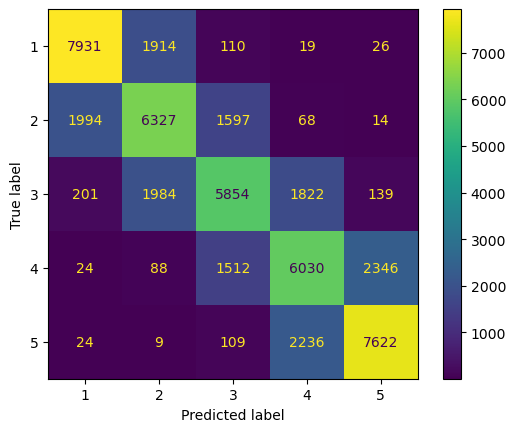

In [155]:
cm = confusion_matrix(y_test, y_pred_gemini_embedding_pca)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
cmd.plot()
plt.show()

In [162]:
print(classification_report(y_test, y_pred_gemini_embedding_pca))

              precision    recall  f1-score   support

           1       0.78      0.79      0.79     10000
           2       0.61      0.63      0.62     10000
           3       0.64      0.59      0.61     10000
           4       0.59      0.60      0.60     10000
           5       0.75      0.76      0.76     10000

    accuracy                           0.68     50000
   macro avg       0.67      0.68      0.67     50000
weighted avg       0.67      0.68      0.67     50000



Similar to previous model with slightly increase in accuracy.

In [163]:
lgb_pca_gemini_embedding_model = pipeline_pca_lgb
lgb_pca_gemini_embedding_model.version = '1.0'
lgb_pca_gemini_embedding_model.python_version = sys.version
lgb_pca_gemini_embedding_model.pandas_version = pd.__version__
lgb_pca_gemini_embedding_model.numpy_version = np.__version__
lgb_pca_gemini_embedding_model.sklearn_version = sklearn_version
lgb_pca_gemini_embedding_model.lightgbm_version = lgb.__version__
lgb_pca_gemini_embedding_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
dump(lgb_pca_gemini_embedding_model, f'{modelpath}/lgb_pca_gemini_embedding_model.joblib')

['../models/lgb_pca_gemini_embedding_model.joblib']

***

# Models Comparison

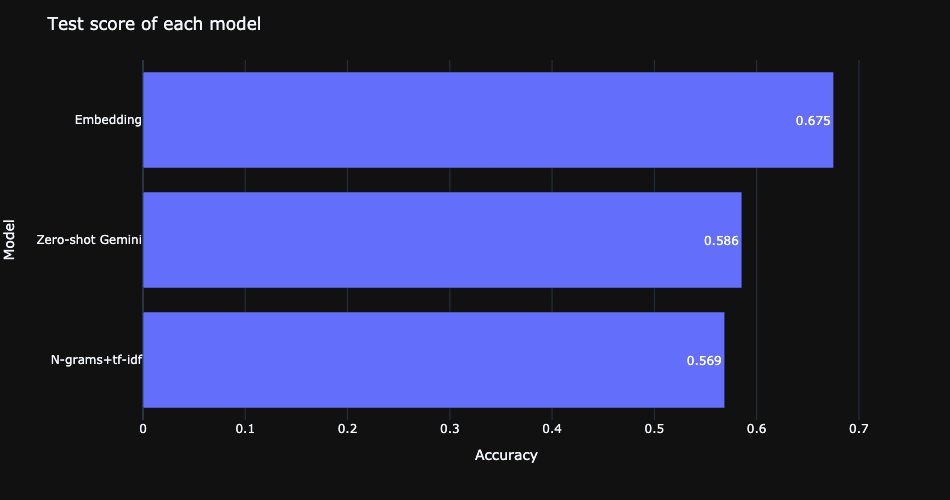

In [130]:
acc = [accuracy_score(y_test, pred) for pred in [y_pred_bw, y_pred_gemini ,y_pred_gemini_embedding_pca]]
fig = px.bar(x=acc, y=['N-grams+tf-idf', 'Zero-shot Gemini', 'Embedding'], text_auto='.3f', width=950, height=500)
fig.update_xaxes(title='Accuracy')
fig.update_yaxes(title='Model')
fig.update_layout(template='plotly_dark', title='Test score of each model')
fig.show('png')

***

Check if more data can help increase the accuracy.

In [46]:
fractions = np.arange(0.1, 1.1, 0.1)
train_size, train_scores, test_scores = learning_curve(pipeline_pca_lgb, X_train_gemini_embedding, y_train, train_sizes=fractions, 
                                                       scoring='accuracy', cv=kf)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134640
[LightGBM] [Info] Number of data points in the train set: 43333, number of used features: 528
[LightGBM] [Info] Start training from score -1.478908
[LightGBM] [Info] Start training from score -1.590307
[LightGBM] [Info] Start training from score -1.631676
[LightGBM] [Info] Start training from score -1.653020
[LightGBM] [Info] Start training from score -1.708274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134640
[LightGBM] [Info] Number of data points in the train set: 86666, number of used features: 528
[LightGBM] [Info] Start training from score -1.491186
[LightGBM] [Info] Start training from score -1.600032
[LightGBM] [Info] Start training from 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134640
[LightGBM] [Info] Number of data points in the train set: 259999, number of used features: 528
[LightGBM] [Info] Start training from score -1.621896
[LightGBM] [Info] Start training from score -1.578140
[LightGBM] [Info] Start training from score -1.550005
[LightGBM] [Info] Start training from score -1.579427
[LightGBM] [Info] Start training from score -1.727222
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134640
[LightGBM] [Info] Number of data points in the train set: 303333, number of used features: 528
[LightGBM] [Info] Start training from score -1.601616
[LightGBM] [Info] Start training from score -1.584621
[LightGBM] [Info] Start training fro

In [47]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

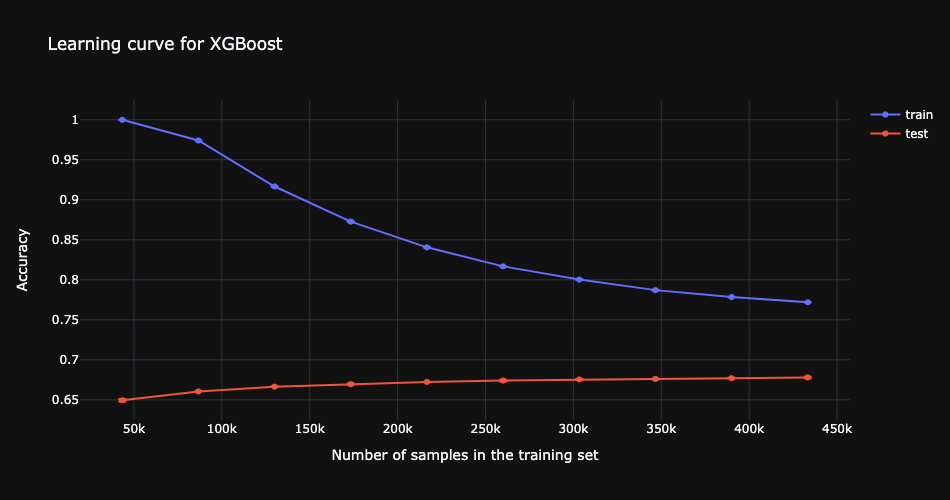

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_size, y=train_scores_mean, name='train',
                         error_y=dict(type='data', array=train_scores_std,visible=True)))
fig.add_trace(go.Scatter(x=train_size, y=test_scores_mean, name='test',
                         error_y=dict(type='data', array=test_scores_std,visible=True)))
fig.update_xaxes(title='Number of samples in the training set')
fig.update_yaxes(title='Accuracy')
fig.update_layout(title='Learning curve for XGBoost', template='plotly_dark', width=950, height=500)
fig.show('png')

Test score looks stable already.